# SMS Spam Classification using Deep Learning

### Siraj Ali

Dataset location: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [1]:
from nltk import stem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

In [2]:
SEED = 42
NLTK_DATA_PATH = ''
SPAM_DATA_PATH = './data/sms.txt'

In [ ]:
if not os.path.exists(NLTK_DATA_PATH):
    nltk.download()
else:
    print('NLTK data already exists at specified path.')

## Read in the data

In [3]:
if os.path.exists(SPAM_DATA_PATH):
    df = pd.read_csv(SPAM_DATA_PATH, delimiter='\t', header=None, names=['label', 'raw'])
else:
    print(f'The data does not exist at path {DATA_PATH}')

In [4]:
df.head()

,label,raw
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# check for nulls
df.isna().sum()

label    0
raw      0
dtype: int64

### Check the distribution of spam and ham

There is about a 13.4% event rate that messages are spam in this dataset.

In [6]:
df.groupby(['label']).count() / df.shape[0]

,raw
label,
ham,0.865937
spam,0.134063


<AxesSubplot:>

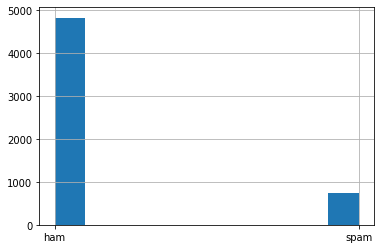

In [7]:
df['label'].hist()

### Check length of messages

Spam messages tend to be much longer than ham messages.

In [8]:
df.loc[:, 'length'] = df['raw'].apply(lambda x: len(x))

<AxesSubplot:>

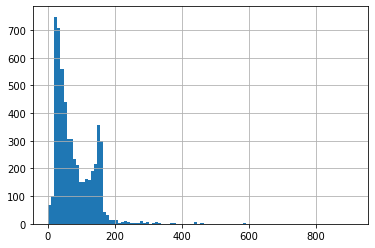

In [9]:
df['length'].hist(bins=100)

<AxesSubplot:>

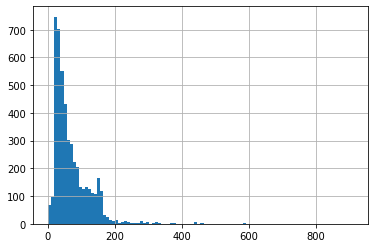

In [10]:
df.query('label == "ham"')['length'].hist(bins=100)

<AxesSubplot:>

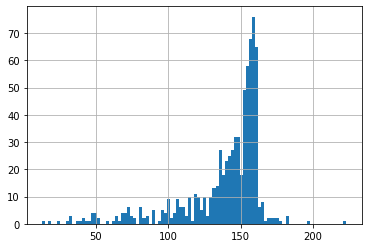

In [11]:
df.query('label == "spam"')['length'].hist(bins=100)

In [12]:
df.groupby('label')['length'].mean()

label
ham      71.482487
spam    138.670683
Name: length, dtype: float64

## Clean the text data

In [13]:
# binarize the target
df['target'] = df['label'].map({'ham': 0, 'spam': 1})

In [14]:
stemmer = stem.SnowballStemmer('english') # Porter2 stemmer
stops = set(stopwords.words())

In [15]:
def process_messages(msg):
    
    # strip whitecase and case-normalize
    msg = msg.lower().strip()
    
    # tokenize word
    words = nltk.word_tokenize(msg)
    
    # remove punctuation
    words = [w for w in words if w.isalnum()]
    
    # remove stopwords
    words = [w for w in words if w not in stops]
    
    # use stemmer to get word stem
    final = ' '.join([stemmer.stem(w) for w in words])
    
    # return 
    return final

df['message'] = df['raw'].apply(process_messages)

In [16]:
dict(df.iloc[0])

{'label': 'ham',
 'raw': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'length': 111,
 'target': 0,
 'message': 'go jurong point crazi avail bugi great world buffet got amor'}

## Train-Test Split

In [17]:
# stratified split to get equal distribution of event rate - 70/30 split for train and test
stratsplit = StratifiedShuffleSplit(test_size=0.3, random_state=SEED)

for train_idx, test_idx in stratsplit.split(df, df["target"]):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]

In [18]:
df_train['target'].value_counts()

0    3377
1     523
Name: target, dtype: int64

In [19]:
df_test['target'].value_counts()

0    1448
1     224
Name: target, dtype: int64

In [20]:
X_train = df_train.drop('target', axis=1)['message'].values
y_train = df_train['target'].values

In [21]:
X_test = df_test.drop('target', axis=1)['message'].values
y_test = df_test['target'].values

## Vectorize the text using Term Frequency - Inverse Document Frequency (TF-IDF)

In [22]:
vectorizer = TfidfVectorizer()

In [23]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Naive Bayes Classifier

In [24]:
bayes = MultinomialNB()
bayes.fit(X_train_vec, y_train)

MultinomialNB()

In [25]:
nb_preds = bayes.predict(X_test_vec)
print(accuracy_score(y_test, nb_preds))
print(roc_auc_score(y_test, nb_preds))

0.9557416267942583
0.8367082675611681


In [26]:
nb_cf_mtrx = confusion_matrix(y_test, nb_preds)
print('TP:', nb_cf_mtrx[0][0])
print('FP:', nb_cf_mtrx[0][1])
print('FN:', nb_cf_mtrx[1][0])
print('TN:', nb_cf_mtrx[1][1])

TP: 1447
FP: 1
FN: 73
TN: 151


The Naive Bayes classifier is not too bad, though many false negatives do indeed get through.

## SVM

In [65]:
svm = SVC(C=1.0, kernel='rbf', probability=True)
svm.fit(X_train_vec, y_train)

SVC(probability=True)

In [66]:
preds = svm.predict(X_test_vec)
print(accuracy_score(y_test, preds))
print(roc_auc_score(y_test, preds))

0.972488038277512
0.899208267561168


In [67]:
sv_cf_mtrx = confusion_matrix(y_test, preds)
print('TP:', sv_cf_mtrx[0][0])
print('FP:', sv_cf_mtrx[0][1])
print('FN:', sv_cf_mtrx[1][0])
print('TN:', sv_cf_mtrx[1][1])

TP: 1447
FP: 1
FN: 45
TN: 179


While better than the Naive Bayes Classifier, the SVM produces a decent rate of false negatives! That's a good number of spam messages getting through.

## Artificial Neural Network

In [30]:
from tensorflow.keras.layers import Dense, Dropout, Activation
import tensorflow as tf

In [90]:
BATCH_SIZE = 32
EPOCHS = 10

In [91]:
ann = tf.keras.models.Sequential()
ann.add(Dense(units=512))
ann.add(Dropout(0.1))
ann.add(Activation('relu'))
ann.add(Dense(units=256))
ann.add(Dropout(0.1))
ann.add(Activation('relu'))
ann.add(Dense(units=1))
ann.add(Activation('sigmoid'))

In [92]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train_vec, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/10
122/122 [==============================] - 2s 11ms/step - loss: 0.3759 - accuracy: 0.8513
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 0.0478 - accuracy: 0.9902
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 5/10
122/122 [==============================] - 1s 12ms/step - loss: 5.2738e-04 - accuracy: 1.0000
Epoch 6/10
122/122 [==============================] - 2s 13ms/step - loss: 2.4223e-04 - accuracy: 1.0000
Epoch 7/10
122/122 [==============================] - 1s 12ms/step - loss: 1.4356e-04 - accuracy: 1.0000
Epoch 8/10
122/122 [==============================] - 2s 14ms/step - loss: 9.5886e-05 - accuracy: 1.0000
Epoch 9/10
122/122 [==============================] - 2s 14ms/step - loss: 7.7127e-05 - accuracy: 1.0000 0s - loss: 8
Epoch 10/10
122/122 [==============================] - 2s 

In [93]:
dl_y_pred = (ann.predict(X_test_vec) > 0.5)

print(accuracy_score(y_test, dl_y_pred))
print(roc_auc_score(y_test, dl_y_pred))

0.9742822966507177
0.9191125690607735


In [94]:
dl_cf_mtrx = confusion_matrix(y_test, dl_y_pred)
print('TP:', dl_cf_mtrx[0][0])
print('FP:', dl_cf_mtrx[0][1])
print('FN:', dl_cf_mtrx[1][0])
print('TN:', dl_cf_mtrx[1][1])

TP: 1440
FP: 8
FN: 35
TN: 189


The overall accuracy of this simple neural network bests both the Naive Bayes and the SVM classifiers; however, slightly more false positives were produced while the number of false negatives decreased.

# Summary

In [95]:
confusion_matrices = [
    nb_cf_mtrx.reshape((4, )),
    sv_cf_mtrx.reshape((4, )),
    dl_cf_mtrx.reshape((4, ))
]

summary_df = pd.DataFrame(
    data=confusion_matrices,
    columns=['TP', 'FP', 'FN', 'TN'],
    index=['Naive Bayes', 'SVM', 'ANN']
)

summary_df

,TP,FP,FN,TN
Naive Bayes,1447,1,73,151
SVM,1447,1,45,179
ANN,1440,8,35,189


C:\Users\siraj\miniconda3\envs\dl4nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


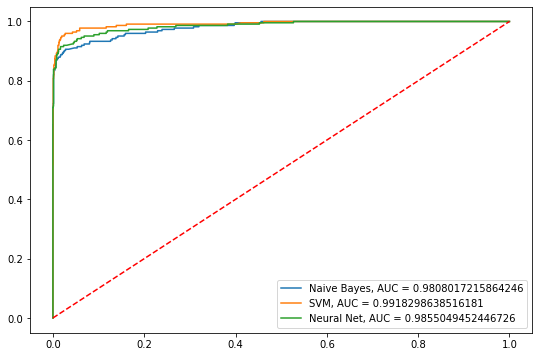

In [99]:
plt.rcParams["figure.figsize"] = (9, 6)

y_pred_proba_nb = bayes.predict_proba(X_test_vec)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_nb)
auc = roc_auc_score(y_test, y_pred_proba_nb)
plt.plot(fpr, tpr, label="Naive Bayes, AUC = " + str(auc))

y_pred_proba_svm = svm.predict_proba(X_test_vec)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svm)
auc = roc_auc_score(y_test, y_pred_proba_svm)
plt.plot(fpr, tpr, label="SVM, AUC = " + str(auc))

y_pred_proba_ann = ann.predict_proba(X_test_vec)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ann)
auc = roc_auc_score(y_test, y_pred_proba_ann)
plt.plot(fpr, tpr, label="Neural Net, AUC = " + str(auc))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.legend(loc=4)
plt.show()